<a href="https://colab.research.google.com/github/Crepopcorn/cat-vs-dog-vit-project/blob/main/vit_l16_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Dogs-vs-Cats classifier (vit_116)**


**1) Pre-load module**

In [ ]:
!pip install tensorflow-addons
!pip install vit-keras
!nvidia-smi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 8.7 MB/s eta 0:00:00
Tue Oct 31 03:43:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
      

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
img_size=[256,256]
train_dir='/content/drive/My Drive/data/train'
test_dir='/content/drive/My Drive/data/val'
!ls '/content/drive/My Drive/data/train'

cat  dog


In [ ]:
from vit_keras import vit, utils
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,Model
#from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


**2) Preprocessing**

In [ ]:
image_size = 256
base_model = vit.vit_l16(
    image_size=image_size,
    activation='relu',
    pretrained=True,
    include_top=False,
    pretrained_top=False,
)

1218991142/1218991142 [==============================] - 4s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 16, 16
  warnings.warn(


In [ ]:
print(base_model.summary())

Model: "vit-l16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 16, 16, 1024)      787456    
                                                                 
 reshape (Reshape)           (None, 256, 1024)         0         
                                                                 
 class_token (ClassToken)    (None, 257, 1024)         1024      
                                                                 
 Transformer/posembed_input  (None, 257, 1024)         263168    
  (AddPositionEmbs)                                              
                                                                 
 Transformer/encoderblock_0  ((None, 257, 1024),       12596224  
  (TransformerBlock)          (None, 16, None, None)       

In [ ]:
for layer in base_model.layers:
    layer.trainable=False

print("Base model layers are freezed!!!")

Base model layers are freezed!!!


In [ ]:
print(base_model.summary())

Model: "vit-l16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 16, 16, 1024)      787456    
                                                                 
 reshape (Reshape)           (None, 256, 1024)         0         
                                                                 
 class_token (ClassToken)    (None, 257, 1024)         1024      
                                                                 
 Transformer/posembed_input  (None, 257, 1024)         263168    
  (AddPositionEmbs)                                              
                                                                 
 Transformer/encoderblock_0  ((None, 257, 1024),       12596224  
  (TransformerBlock)          (None, 16, None, None)       

In [ ]:
x = Dropout(0.2)(base_model.output)
x = Flatten()(x)
x = Dense(2,'softmax')(x)

model = Model(inputs=base_model.input,outputs=x)

In [ ]:
print("Final Model is:\n",model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 16, 16, 1024)      787456    
                                                                 
 reshape (Reshape)           (None, 256, 1024)         0         
                                                                 
 class_token (ClassToken)    (None, 257, 1024)         1024      
                                                                 
 Transformer/posembed_input  (None, 257, 1024)         263168    
  (AddPositionEmbs)                                              
                                                                 
 Transformer/encoderblock_0  ((None, 257, 1024),       12596224  
  (TransformerBlock)          (None, 16, None, None)         

In [ ]:
opt=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [ ]:
RANDOM_SEED=123
train_datagen = ImageDataGenerator(
    width_shift_range=0.4,
    height_shift_range=0.4,
    rescale=1.0/255,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255,
)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    color_mode='rgb',
    target_size=img_size,
    batch_size=64,
    class_mode='categorical',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    test_dir,
    color_mode='rgb',
    target_size=img_size,
    batch_size=64,
    class_mode='categorical',
    seed=RANDOM_SEED
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


**3) Train Model**

In [ ]:
import time
start = time.time()
hist = model.fit(
    train_generator,
    epochs=15,
    validation_data = validation_generator
)

end = time.time()
print("Total time taken: ",end-start)

Epoch 1/15
313/313 [==============================] - 1474s 5s/step - loss: 0.0434 - accuracy: 0.9839 - val_loss: 0.0173 - val_accuracy: 0.9950
Epoch 2/15
313/313 [==============================] - 1480s 5s/step - loss: 0.0414 - accuracy: 0.9847 - val_loss: 0.0161 - val_accuracy: 0.9954
Epoch 3/15
313/313 [==============================] - 1481s 5s/step - loss: 0.0436 - accuracy: 0.9841 - val_loss: 0.0154 - val_accuracy: 0.9952
Epoch 4/15
313/313 [==============================] - 1481s 5s/step - loss: 0.0445 - accuracy: 0.9837 - val_loss: 0.0181 - val_accuracy: 0.9952
Epoch 5/15
313/313 [==============================] - 1481s 5s/step - loss: 0.0432 - accuracy: 0.9846 - val_loss: 0.0170 - val_accuracy: 0.9948
Epoch 6/15
313/313 [==============================] - 1480s 5s/step - loss: 0.0447 - accuracy: 0.9836 - val_loss: 0.0196 - val_accuracy: 0.9952
Epoch 7/15
313/313 [==============================] - 1481s 5s/step - loss: 0.0466 - accuracy: 0.9833 - val_loss: 0.0212 - val_accuracy:

**4) Plot Graph**

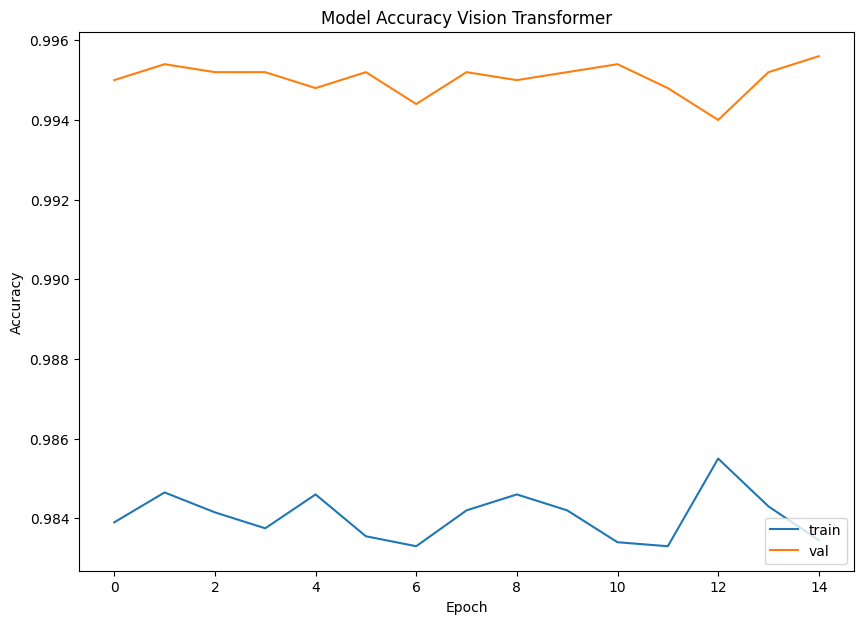

In [ ]:
# plotting the figure for accuracy
plt.figure(figsize=(10,7))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy Vision Transformer')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

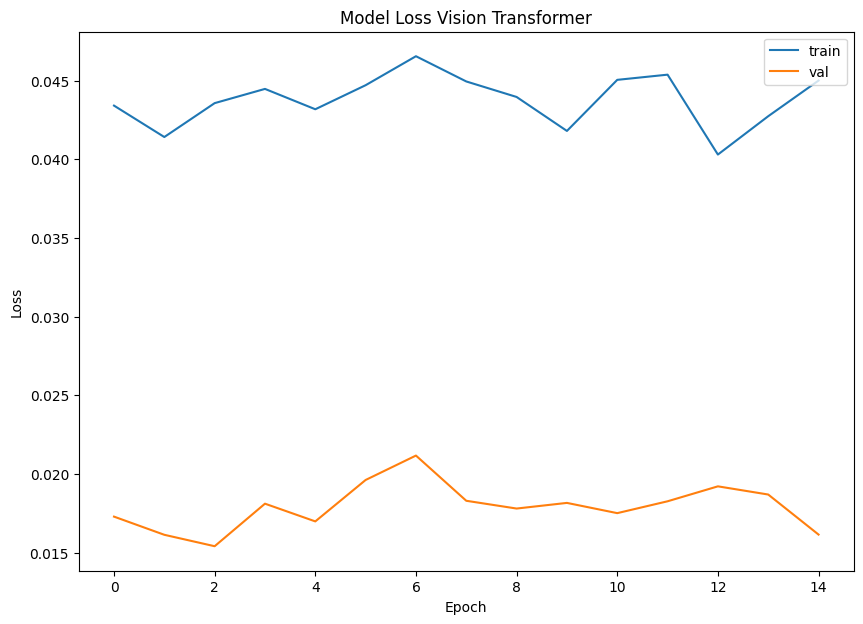

In [ ]:
# plotting the figure for loss
plt.figure(figsize=(10,7))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss Vision Transformer')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
model.save('dogCat_vit_l16.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
